# Bias detection using distributional models within the Maltese language

## 0. Table of Contents

**1. Pre-requisites:** must be run every time  
**2. Load Corpus:** only if training  
**3. Train models:** only if training  
**4. Test models:** for testing saved models 

## 1. Pre-requisites

Import all required libraries

In [1]:
from gensim.models.keyedvectors import KeyedVectors
from debiaswe.we import WordEmbedding
from utils.mweat import calculate_bias
from gensim.models import TfidfModel
from utils.callback import callback
from gensim.models import FastText
from gensim.models import Word2Vec
import sklearn.feature_extraction
from utils.plot import plotBias
import matplotlib.pyplot as plt
from numpy.linalg import norm
from debiaswe import debias
from gensim import corpora
import sklearn.naive_bayes
import gensim.downloader
from debiaswe import we
import sklearn.datasets
import sklearn.manifold
import sklearn.metrics
import numpy as np
import gensim
import random
import pickle
import scipy
import json
import nltk
import math
import re


## 2. Load Corpus

`load_traditional` $\rightarrow$ load corpus document by document  
`load_modern` $\rightarrow$ load corpus token by token

In [ ]:
data = []
documents = []

load_traditional = False
load_modern = True

for file in os.listdir("../dataset/dataset-neutral"):

    with open(f"../dataset/dataset-neutral/{file}", "r", encoding="utf8") as f:
        text = f.read()

    if load_traditional:
        document = re.sub('[^a-zA-Z ]+', "", text)
        documents.append(document) 
    elif load_modern:
        sentences = nltk.tokenize.sent_tokenize(text)
        for sentence in sentences:
            tokens = nltk.tokenize.word_tokenize(sentence)
            tokens = [token for token in tokens if re.match('^[a-zA-Z]+$', token)]
            data.append(tokens)

    print(f"Finished with {file}!")


## 3. Train models

### 3.1. Training Word2Vec

In [ ]:
word2vec_model = Word2Vec(
    data,
    size=100,
    window=10,
    min_count=2,
    workers=4
)

# Train the model
word2vec_model.train(data, total_examples=len(data), epochs=10, compute_loss=True, callbacks=[callback()])

# Save the model and embedding for later use.
word2vec_model.save('../saved/neutral/word2vec/word2vec.model')
word2vec_model.wv.save_word2vec_format('../saved/neutral/word2vec/word2vec_embedding.bin', binary=True)

### 3.2. Training FastText

In [ ]:
fasttext_model = FastText(
    data, 
    size=100, 
    window=10, 
    min_count=2, 
    workers=4
)

fasttext_model.train(data, total_examples=len(data), epochs=10)

fasttext_model.save('../saved/neutral/fasttext/fasttext.model')

### 3.3. Fitting TF-IDF Vectorizer

In [ ]:
tfidf_featuriser = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=None)
tfidf_featuriser.fit(documents)
tfidf_docterm_matrix = tfidf_featuriser.transform(documents)

pickle.dump(tfidf_featuriser, open("../saved/tfidf_vectorizer/tfidf_featuriser.pickle", "wb"))
pickle.dump(tfidf_docterm_matrix, open("../saved/tfidf_vectorizer/tfidf_docterm_matrix.pickle", "wb"))

## 4. Test models
### 4.1. Test word2vec or FastText

In [188]:
mode = "original"
name = "word2vec"

E = WordEmbedding(f"../saved/{mode}/{name}/{name}.model")

*** Reading data from ../saved/original/word2vec/word2vec.model
(321253, 100)
321253 words of dimension 100 : li, u, ta, ma, ..., zeelie, ballboys, omoroo, comission
321253 words of dimension 100 : li, u, ta, ma, ..., zeelie, ballboys, omoroo, comission


Get gender direction $\overrightarrow{g}$...

In [189]:
with open(f"../saved/data/s0.json", "r") as f:
    s0 = json.load(f)
g = we.doPCA(s0, E).components_[0]

Get pairs in $Male:Female$ format ...

In [91]:
name = "s1"

with open(f"../saved/data/{name}.json", "r") as f:
    key_words = json.load(f)
    print("Loaded maltese pairs...")

male = [p[0] for p in key_words]
female = [p[1] for p in key_words]

Loaded maltese pairs...


$O_1$: Calculate and visualise $|b_i|$ for every profession...

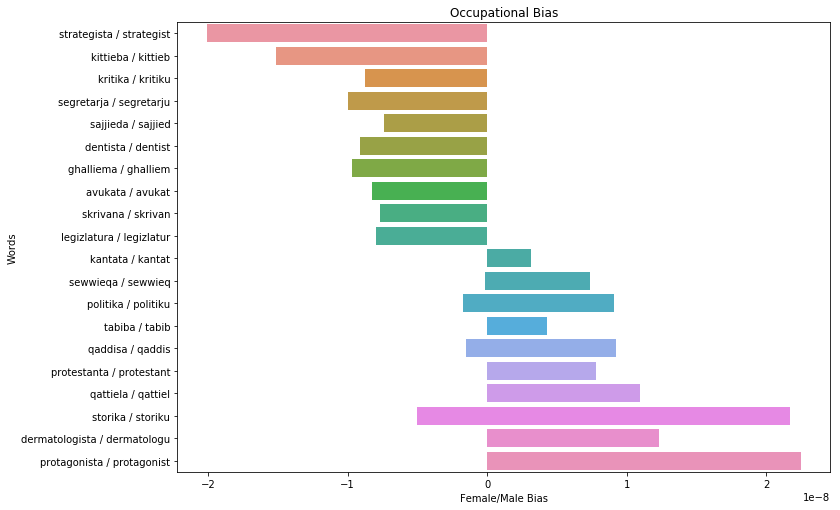

In [88]:
mb = {}
fb = {}
b = []

for i, w in enumerate(key_words):
    male = w[0]
    female = w[1]

    try:
        mb[male] = E.v(male).dot(g)
        fb[female] = E.v(female).dot(g)
    except KeyError:
        continue

    total_bias = mb[male] + fb[female]
    b.append([female, male, total_bias])

b = sorted(b, key=lambda x: x[2])
extremes = b[0:10] + b[-10:]

plotBias(mb, fb, extremes, title="Occupational Bias")

$O_2$: Use the $MWEAT$ metric to quantify bias

In [87]:
M = [x[0] for x in s0]
F = [x[1] for x in s0]
bias = calculate_bias(E, M, F, key_words)

avg_bias = np.array([bias[k] for k in bias]).mean()

print(f"Average bias: {avg_bias}")
print("Top 20 biased terms according to the WEAT metric...")
dict(sorted(bias.items(), key=lambda x: x[1], reverse=True)[0:20])


Average bias: 0.04748983095872544
Top 20 biased terms according to the WEAT metric...


{'tabib / tabiba': 0.1429186575114727,
 'ghalliem / ghalliema': 0.132235299795866,
 'kantat / kantata': 0.11934156715869904,
 'sajjied / sajjieda': 0.11179651971906424,
 'deputat / deputata': 0.09644275903701782,
 'haddiem / haddiema': 0.0753039913251996,
 'gurnalist / gurnalista': 0.06912355870008469,
 'tekniku / teknika': 0.06638534227386117,
 'dermatologu / dermatologista': 0.0641350339865312,
 'student / studenta': 0.0616608327254653,
 'spizjar / spizjara': 0.06048893742263317,
 'matematiku / matematika': 0.059278551023453474,
 'wejter / wejtress': 0.05905241705477238,
 'sportiv / sportiva': 0.05801405943930149,
 'artist / artista': 0.05621873587369919,
 'psikologu / psikologa': 0.04913327656686306,
 'sewwieq / sewwieqa': 0.036851362441666424,
 'protestant / protestanta': 0.029652281664311886,
 'avukat / avukata': 0.02793370303697884,
 'attur / attrici': 0.026313455775380135}

Hard debias word embedding given gender direction $\overrightarrow{g}$, $E$ (equality sets) and $G$ (gender-specific words)...

In [187]:
with open('../saved/data/equality_sets.json', "r") as f:
    e = json.load(f)

with open('../saved/data/gender_specific.json', "r") as f:
    G = json.load(f)

debias.debias(E, G, g, e, we)

321253 words of dimension 100 : li, u, ta, ma, ..., zeelie, ballboys, omoroo, comission
{('NANNU', 'NANNA'), ('tieghu', 'taghha'), ('Rejiet', 'Irgejjen'), ('nannu', 'nanna'), ('MISSIER', 'OMM'), ('qassis', 'soru'), ('Monasteru', 'Kunvent'), ('TESTOSTERONE', 'ESTROGENU'), ('tifel', 'tifla'), ('ulied', 'ibniet'), ('Qassis', 'Soru'), ('Paternita', 'Maternita'), ('ZIJU', 'ZIJA'), ('Nannu', 'Nanna'), ('Neputi', 'Neputija'), ('monasteru', 'kunvent'), ('hu', 'hi'), ('HU', 'HI'), ('Tifel', 'Tifla'), ('IRGIEL', 'NISA'), ('missier', 'omm'), ('Ziju', 'Zija'), ('MASKILI', 'FEMMINIL'), ('Ulied', 'Ibniet'), ('Maskili', 'Femminil'), ('maskili', 'femminil'), ('testosterone', 'estrogenu'), ('QASSIS', 'SORU'), ('MONASTERU', 'KUNVENT'), ('Sinjur', 'Sinjura'), ('NEPUTI', 'NEPUTIJA'), ('SINJUR', 'SINJURA'), ('SUBIEN', 'BNIET'), ('Missier', 'Omm'), ('missirijiet', 'ommijiet'), ('subien', 'bniet'), ('Testosterone', 'Estrogenu'), ('ziju', 'zija'), ('Hu', 'Hi'), ('REJIET', 'IRGEJJEN'), ('ULIED', 'IBNIET'), ('r

Generate best analogies...

In [190]:
a_gender = E.best_analogies_dist_thresh(g, topn=100, max_words=10000,eps=0.5)

for (a,b,c) in a_gender:
    print(a+"-"+b+" : "+str(c))

Computing neighbors
Mean: 33.8608
Median: 22.0
missier-omm : 0.84921455
tieghu-taghha : 0.8451467
missieru-ommha : 0.83486176
kantant-kantanta : 0.8232137
uliedu-uliedha : 0.80376935
anzjan-anzjana : 0.8028375
hajtu-hajjitha : 0.8022094
ibnu-bintha : 0.7950264
mar-marret : 0.7949054
telaq-telqet : 0.7931004
rega-regghet : 0.7921659
missieri-ommi : 0.78995687
mieghu-maghha : 0.7786037
jibqa-tibqa : 0.77311003
joqghod-toqghod : 0.77043056
tifel-tifla : 0.76949316
naghtuh-naghtuha : 0.7693255
idejh-idejha : 0.76453316
spicca-spiccat : 0.76141036
jaghtuh-jaghtuha : 0.75754106
ammetta-ammettiet : 0.7545197
kellux-kellhiex : 0.74932194
jaqla-taqla : 0.74158514
iservi-isservi : 0.7414067
gurnalist-gurnalista : 0.7409097
ghajnejh-ghajnejha : 0.73913
jikteb-tikteb : 0.7387587
igib-iggib : 0.7377107
jigbor-tigbor : 0.7366921
hadem-hadmet : 0.7353806
qalbu-qalbha : 0.73386586
ragel-mara : 0.7337685
jgholli-tgholli : 0.7329428
jiftah-tiftah : 0.7321501
jkollux-jkollhiex : 0.73203087
qabad-qabdet :

... or manual analogies $A : X :: B : Y$...

In [ ]:
A = "ragel"
X = "missier"
B = "mara"
Y = E.most_similar(A, X, B, topn=10)

print(f"{A} : {X} :: {B} : ?")
print(f"\n\nAnswers: {Y}")

### 4.2. Test TFIDF Vectorizer

In [5]:
tfidf_docterm_matrix = pickle.load(open("../saved/original/tfidf_vectorizer/tfidf_docterm_matrix.pickle", "rb"))
tfidf_featuriser = pickle.load(open("../saved/original/tfidf_vectorizer/tfidf_featuriser.pickle", "rb"))

print(tfidf_docterm_matrix.shape)

(25, 572229)


In [14]:
A = "qasis"
X = "missier"
B = "soru"
Y = "omm"

vec1 = tfidf_docterm_matrix.transpose()[tfidf_featuriser.vocabulary_[A], :]
vec2 = tfidf_docterm_matrix.transpose()[tfidf_featuriser.vocabulary_[X], :]
vec3 = tfidf_docterm_matrix.transpose()[tfidf_featuriser.vocabulary_[B], :]
vec4_truth = tfidf_docterm_matrix.transpose()[tfidf_featuriser.vocabulary_[Y], :]

vec4_pred = vec2 + vec3 - vec1

print(sklearn.metrics.pairwise.cosine_similarity(vec4_truth, vec4_pred)[0, 0])

0.9539474948091548
